In [1]:
import torch, torchvision
import torchvision.models as models

import matplotlib.pyplot as plt
from PIL import Image


Very Deep Convolutional Networks for Large-Scale Image Recognition, Karen Simonyan, Andrew Zisserman

https://arxiv.org/abs/1409.1556


![](./data/vgg_fig1.png)

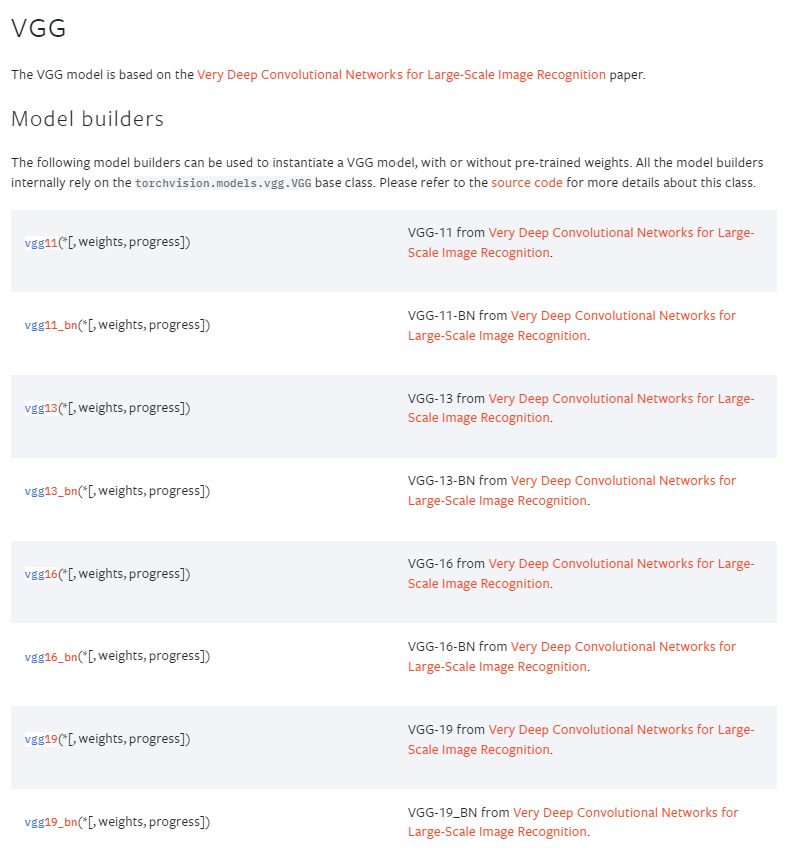

논문보면 conv net에 대한 이야기하고 5개의 variation, vgg11,vgg13,vgg16,vgg19 layer의 configuration을 제안하고 test를 진행함.
test시 top-5 error가 얼마나 나오는지 보여줌.  test할때 앙상블했을때 성능이 어떻게 달라지는지 보여줌. 그래서 앙상블한 결과도 보여줌.

pytorch doc에서 보면 vgg에 대한게 있음.
pytorch에서 vgg에 대한 network전체를 제공함.

vgg11은 configuration A 라고 불림. 
이후 batch normalization이라는 technique이 network학습시 중요한 역할을 한다. batch norm을 포함하는 vgg도제공한다.
그래서 configuration A,B,C,D,E까지  제공함

In [3]:
## alexnet과 마찬가지로 feature extractor와 classifier로 구성됨.
## 차후에 globalavgpooling해서 이미지 전체의 사이즈를 244x244가 1/32으로 줄였을텐데
## 그걸 7x7 size를 1x1 spartial resolution으로 다 없애주는 역할을 한다.

## vgg network의 특징은 모두 3x3 kernel과 stride, padding이 1x1로 구성되어있다.
## input chaanel이 3 이고 ouput chaanel이 64이네. 
## 즉 채널을 키우고, spartial size를 줄이면서 high level semantist를 점점 인코딩하는형태가됨
## 마지막으로 1000개의 클래스를 마지막 fc layer를 통과시키면서 만들게된다.
models.vgg16()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
cifar10 = torchvision.datasets.CIFAR10(root='./', download=True)

## compose라는 모듈은 한번에 여러개를 받을수있다.
to_tensor = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                ## torchvision.transforms.ColorJitter(0,3), ## 추가도된다.
                torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
                                ])

vgg16 = models.vgg16(pretrained=True)   ## model initialize

Files already downloaded and verified


In [12]:
for img in cifar10:

    img = to_tensor(img[0])
    
    print(img.shape)    ## 3채널이구나.
    
    logit = vgg16(img.unsqueeze(0))
    
    print(logit.shape)
    break

torch.Size([3, 32, 32])
torch.Size([1, 1000])


## Make dataloader



See the document!

https://pytorch.org/docs/stable/data.html

In [13]:
## dataloader를 만들어보자.
## model의 이미지들을 batchfy해줘서 minibatch로 확률을 강화할수 있는 좋은함수다.
## class를 정의
## transform : data에서 변환이 되서 tensor type으로 변환되서 output을 내뿜는다는 의미
cifar10 = torchvision.datasets.CIFAR10(root='./', download=True, transform=to_tensor)  ## torch.utils.data.Dataset :  이것도 dataset class이다.
## class에 대해서 dataloader라는 instance를 다시 만들어주는것. 
## dataloader에서는 data를 받아서 batch는 얼마큼 줄것인지, shuffle은 어떤 순서가 shuffle이 안되면 network가 순서를
## 외울수 있다.  그래서 shuffle =true해준다. num_worker는 cpu의 멀티프로세싱을 얼마나 해줄지 정하는것.
## 디버깅할때는 0을 쓴다. 왜냐면 멀티프로세싱 쓰면 어디서 에러가 난지 찾기 어려우니깐!
dataloader = torch.utils.data.DataLoader(cifar10, batch_size=8, shuffle=True, num_workers=2)

Files already downloaded and verified


In [14]:
dataloader  ## dataloader의 type instance가 만들어진다.

In [17]:
for idx, data in enumerate(dataloader):
#     
    img, gt = data
    
    print(img.shape, gt.shape)
    

## 아래는 normalization되어서 image가 깨져서 나올것이다.
## 위의 normalize없애고 아래 코드 실행하면 해당 이미지가 안깨지고보일것이다.
#     for im in img:
#         plt.imshow(torchvision.transforms.ToPILImage()(im))
#         plt.show()
    
    ## TODO: run the vgg16 network
    logits = vgg16(img)
    
    print(logits.shape) ## 1000개의 class를 예측함.
    ## imagenet으로 pretrained 되어있기 떄문에 1000개의 class를 예측하는거로 되어있음
    ## cifar10와는 안맞으므로 마지막 layer를 10가지를 예측하도록 MLP를 바꾸고
    ## fine tunning을 시켜주면 cifar10에대해서 잘 맞추는 모델이 나올것이다.
    
    break

torch.Size([8, 3, 32, 32]) torch.Size([8])
torch.Size([8, 1000])


## Model variations 

VGG11

VGG16

VGG19

In [20]:
# models.vgg11
models.vgg11()



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [23]:
models.vgg11_bn()
## 사이에 batchNorm2d가 포함되어 있음을 알수있다.

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [24]:
models.vgg19()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd